In [1]:
!du -h *

In [2]:
!cat Variables\ CCA.txt






precmaxext.tif= Precipitación máxima extrema acumulada mensual (1902-2011)

In [3]:
import gdal, ogr
import numpy as np
from matplotlib import pyplot

import fiona
import rasterio
import rasterio.mask

import psycopg2

raster_name = "./mex_wc2.1_30s_bio_19.tif"
no_percentiles = 20
id_fuente_bioclimatica = 17
label = 'Precipitation of Coldest Quarter'
unidad = 'mm'

### Getting data and info of layer

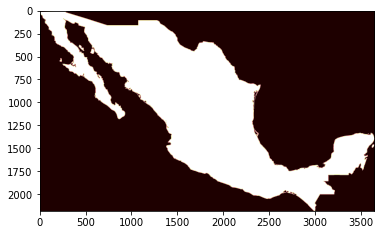

In [4]:
src = rasterio.open(raster_name)
pyplot.imshow(src.read(1), cmap='pink')
pyplot.show()

In [5]:
layer = gdal.Open(raster_name)

raster_info = {
                'xsize': layer.RasterXSize,
                'ysize': layer.RasterYSize,
                'geo_transformation': layer.GetGeoTransform(),
                'projection': layer.GetProjection()
              }

data = layer.ReadAsArray()

raster_info

{'xsize': 3645,
 'ysize': 2180,
 'geo_transformation': (-117.12359619140625,
  0.008334317096139831,
  0.0,
  32.718318939208984,
  0.0,
  -0.008334971786639013),
 'projection': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'}

### Closing raster file

In [6]:
layer = None

### How looks the extracted data

In [7]:
data

array([[-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       ...,
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38]],
      dtype=float32)

In [8]:
data.shape

(2180, 3645)

### Shape, max and min of extracted data

In [9]:
[data.shape, data.max(), data.min()]

[(2180, 3645), 976.0, -3.4e+38]

### Masking nondata value

In [10]:
data = np.ma.masked_less(data, value=-3e+38)

In [11]:
data

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

In [12]:
p = np.linspace(start=0, stop=100, num=no_percentiles + 1) 
percentiles = np.nanpercentile(np.where(np.logical_not(data.mask), data, np.NAN), p)

In [13]:
percentiles

array([  0.,  20.,  24.,  26.,  29.,  31.,  34.,  36.,  39.,  42.,  46.,
        52.,  59.,  66.,  74.,  88., 105., 123., 148., 194., 976.])

In [14]:
labels = ['{}:{}'.format(f"{interval[0]:.3f}", f"{interval[1]:.3f}") for interval in zip(percentiles[:-1],percentiles[1:])]
labels

['0.000:20.000',
 '20.000:24.000',
 '24.000:26.000',
 '26.000:29.000',
 '29.000:31.000',
 '31.000:34.000',
 '34.000:36.000',
 '36.000:39.000',
 '39.000:42.000',
 '42.000:46.000',
 '46.000:52.000',
 '52.000:59.000',
 '59.000:66.000',
 '66.000:74.000',
 '74.000:88.000',
 '88.000:105.000',
 '105.000:123.000',
 '123.000:148.000',
 '148.000:194.000',
 '194.000:976.000']

In [15]:
data.filled(2*percentiles[-1])

array([[1952., 1952., 1952., ..., 1952., 1952., 1952.],
       [1952., 1952., 1952., ..., 1952., 1952., 1952.],
       [1952., 1952., 1952., ..., 1952., 1952., 1952.],
       ...,
       [1952., 1952., 1952., ..., 1952., 1952., 1952.],
       [1952., 1952., 1952., ..., 1952., 1952., 1952.],
       [1952., 1952., 1952., ..., 1952., 1952., 1952.]], dtype=float32)

### Reclassfying data

In [16]:
reclass = np.searchsorted(percentiles[1:], data.filled(2*percentiles[-1]))
reclass

array([[20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20, 20],
       ...,
       [20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20, 20]])

In [17]:
np.unique(reclass, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 array([ 135735,  162225,   94346,  153107,  107692,  135130,   89259,
         139207,  125891,  113792,  125384,  129555,  122021,  112136,
         127569,  126229,  119118,  128462,  121352,  124001, 5453889]))

In [18]:
reclass.shape

(2180, 3645)

In [19]:
reclass += 1
reclass = np.ma.masked_equal(reclass, percentiles.shape[0])

In [20]:
reclass

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=21)

In [21]:
np.unique(reclass, return_counts=True)

(masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                    17, 18, 19, 20, --],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False, False,
                    False, False, False, False,  True],
        fill_value=21),
 array([ 135735,  162225,   94346,  153107,  107692,  135130,   89259,
         139207,  125891,  113792,  125384,  129555,  122021,  112136,
         127569,  126229,  119118,  128462,  121352,  124001, 5453889]))

In [22]:
reclass.dtype.name ## 5

'int64'

### Turning reclassified data into a raster

In [23]:
rows, cols = reclass.shape
projection = raster_info['projection']
geo_transformation = raster_info['geo_transformation']

print(projection,'-', geo_transformation)

driver = gdal.GetDriverByName('GTiff')
ds = driver.Create('./reclassified_raster.tif', cols, rows, 1, 5)
ds.SetGeoTransform(geo_transformation)
ds.SetProjection(projection)

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]] - (-117.12359619140625, 0.008334317096139831, 0.0, 32.718318939208984, 0.0, -0.008334971786639013)


0

In [24]:
nodata = reclass.fill_value
nodata

21

In [25]:
reclass = reclass.filled()

In [26]:
reclass

array([[21, 21, 21, ..., 21, 21, 21],
       [21, 21, 21, ..., 21, 21, 21],
       [21, 21, 21, ..., 21, 21, 21],
       ...,
       [21, 21, 21, ..., 21, 21, 21],
       [21, 21, 21, ..., 21, 21, 21],
       [21, 21, 21, ..., 21, 21, 21]])

In [27]:
np.unique(reclass, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21]),
 array([ 135735,  162225,   94346,  153107,  107692,  135130,   89259,
         139207,  125891,  113792,  125384,  129555,  122021,  112136,
         127569,  126229,  119118,  128462,  121352,  124001, 5453889]))

In [28]:
band = ds.GetRasterBand(1)
band.WriteArray(reclass)

band.SetNoDataValue(float(nodata))
band.FlushCache()

#ds.SetGeoTransform(geo_transformation)
#ds.SetProjection(projection)

ds = None

#driver = gdal.GetDriverByName('GTiff')
#ds = driver.Create('./reclassified_raster.tif', cols, rows, 1, 5)

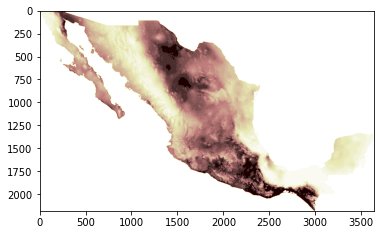

In [29]:
src = rasterio.open("./reclassified_raster.tif")
pyplot.imshow(src.read(1), cmap='pink')
pyplot.show()

### Obtaining polygons from db

In [30]:
with fiona.open("./muni_2016gw.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
    cves = [feature['properties']["CVE_ENT"] + feature['properties']["CVE_MUN"] for feature in shapefile]
    print(shapefile[0]['properties'])
    
    
N = len(shapes)
cells_bins = {}
counts_d = {i:0 for i in range(1, no_percentiles + 2)}
    
with rasterio.open("./reclassified_raster.tif") as src:
    for i in range(N):
        feature = shapes[i]
        out_image, out_transform = rasterio.mask.mask(src, [feature], crop=True)
        bins, counts = np.unique(out_image, return_counts=True)
        for j in range(len(bins)):
            counts_d[bins[j]] += counts[j]
        if cves[i] in cells_bins.keys():
            cells_bins[cves[i]] += [b for b in bins if b != no_percentiles + 1]
            cells_bins[cves[i]] = list(set(cells_bins[cves[i]]))
        else:
            cells_bins[cves[i]] = [b for b in bins if b != no_percentiles + 1]

OrderedDict([('OBJECTID', 1), ('CVE_ENT', '01'), ('NOM_ENT', 'Aguascalientes'), ('CVE_MUN', '002'), ('NOM_MUN', 'Asientos'), ('CVEGEO', '01002'), ('AREA', 54337.42658), ('PERIMETER', 192.09643), ('COV_', 0.0), ('COV_ID', 1.0)])


In [31]:
cells_bins

{'01002': [5, 6, 7, 8, 9],
 '01011': [5, 6, 7, 8],
 '01007': [6, 7, 8, 9, 10, 11],
 '01008': [6, 7, 8, 9, 10, 11],
 '01005': [5, 6, 7, 8, 9, 10],
 '01009': [6, 7, 8, 9],
 '01001': [4, 5, 6, 7, 8, 9],
 '01006': [6, 7, 8, 9, 10],
 '01010': [5, 6, 7, 8, 9],
 '01003': [6, 7, 8, 9, 10, 11],
 '01004': [7, 8, 9],
 '02005': [18, 19, 20],
 '02003': [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 '02004': [18, 19, 20],
 '02002': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20],
 '02001': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20],
 '03008': [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 '03009': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 '03003': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 '03001': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 '03002': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 '04007': [19, 20],
 '04002': [14, 15, 16],
 '04010'

In [32]:
counts_d

{1: 135465,
 2: 161970,
 3: 94261,
 4: 152822,
 5: 107592,
 6: 134954,
 7: 89088,
 8: 139052,
 9: 125798,
 10: 113713,
 11: 125142,
 12: 129234,
 13: 121452,
 14: 111947,
 15: 127260,
 16: 126014,
 17: 119055,
 18: 128375,
 19: 121188,
 20: 123731,
 21: 3384878}

In [33]:
conn = psycopg2.connect("dbname=epi_puma_1 user=postgres port=5433 host=10.90.0.38 password=!37JzLg+9M2RAu72")
cur= conn.cursor()
cur.execute("SELECT DISTINCT gridid_munkm, \"CVE_ENT\"||\"CVE_MUN\" FROM grid_munkm_aoi")
map_cell_cve = cur.fetchall()
cur.close()
conn.close()

In [34]:
map_cell_cve = {t[1]:t[0] for t in map_cell_cve}
map_cell_cve

{'08048': 204,
 '20420': 1194,
 '30173': 2181,
 '20294': 1268,
 '07030': 172,
 '07097': 84,
 '20133': 1204,
 '14015': 570,
 '14087': 611,
 '20514': 1424,
 '20299': 1286,
 '21089': 1634,
 '20244': 1006,
 '21111': 1624,
 '16049': 835,
 '26063': 1923,
 '30073': 2087,
 '20126': 1310,
 '14125': 630,
 '23003': 1806,
 '21001': 1603,
 '20057': 1546,
 '12077': 426,
 '14097': 537,
 '10022': 317,
 '28006': 1998,
 '20344': 1195,
 '12041': 386,
 '19033': 952,
 '31002': 2337,
 '29027': 2052,
 '02004': 14,
 '20065': 1255,
 '21171': 1735,
 '28011': 2003,
 '20235': 1505,
 '20492': 1159,
 '20186': 1038,
 '15013': 760,
 '13028': 477,
 '20162': 1217,
 '32002': 2406,
 '20083': 1396,
 '30094': 2158,
 '20470': 1557,
 '23001': 1809,
 '20407': 1116,
 '09007': 278,
 '19023': 985,
 '08034': 228,
 '16063': 841,
 '30122': 2188,
 '14111': 571,
 '30028': 2255,
 '26002': 1897,
 '07108': 90,
 '17003': 915,
 '30034': 2257,
 '20409': 1197,
 '20374': 1270,
 '15112': 694,
 '27017': 1967,
 '13063': 475,
 '21108': 1609,
 '1

In [35]:
gridid_bins = dict()
for cb in cells_bins:
    gridid_bins[map_cell_cve[cb]] = cells_bins[cb]

In [36]:
gridid_bins

{1: [5, 6, 7, 8, 9],
 2: [5, 6, 7, 8],
 3: [6, 7, 8, 9, 10, 11],
 4: [6, 7, 8, 9, 10, 11],
 5: [5, 6, 7, 8, 9, 10],
 6: [6, 7, 8, 9],
 7: [4, 5, 6, 7, 8, 9],
 8: [6, 7, 8, 9, 10],
 9: [5, 6, 7, 8, 9],
 10: [6, 7, 8, 9, 10, 11],
 11: [7, 8, 9],
 12: [18, 19, 20],
 13: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 14: [18, 19, 20],
 15: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 16: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 17: [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 18: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 19: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 20: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 21: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 22: [19, 20],
 23: [14, 15, 16],
 24: [15, 16, 17, 18, 19],
 25: [16, 17, 18, 19, 20],
 26: [14, 15, 16, 17],
 27: [16, 17, 18, 19],
 28: [13, 14, 15, 16],
 29: [14, 15, 16],
 30: [15, 16, 17, 18],
 31: [15, 16, 17, 18],
 32: [13, 14, 15, 16

In [37]:
d_bins_gridid = {i:[] for i in range(1, no_percentiles + 1)}

for i in range(1, no_percentiles + 1):
    for cell in gridid_bins:
        if i in gridid_bins[cell]:
            d_bins_gridid[i].append(cell)

In [38]:
for i in range(1, no_percentiles + 1):
    print(i, len(d_bins_gridid[i]))

1 815
2 935
3 898
4 978
5 938
6 980
7 904
8 913
9 827
10 788
11 736
12 634
13 545
14 484
15 476
16 490
17 500
18 510
19 491
20 342


In [39]:
s = 0
for i in range(1, no_percentiles + 1):
    s += len(d_bins_gridid[i])
s

14184

In [40]:
d_bins_gridid

{1: [15,
  16,
  17,
  19,
  73,
  76,
  79,
  80,
  82,
  84,
  88,
  90,
  91,
  93,
  94,
  95,
  98,
  101,
  102,
  105,
  109,
  112,
  114,
  117,
  118,
  128,
  129,
  135,
  136,
  140,
  151,
  153,
  155,
  159,
  161,
  162,
  164,
  165,
  166,
  167,
  172,
  173,
  174,
  177,
  181,
  183,
  184,
  187,
  188,
  189,
  192,
  193,
  195,
  201,
  203,
  205,
  206,
  208,
  211,
  213,
  218,
  222,
  224,
  230,
  232,
  234,
  239,
  256,
  269,
  270,
  276,
  278,
  289,
  294,
  305,
  306,
  315,
  330,
  333,
  367,
  368,
  369,
  370,
  371,
  372,
  374,
  375,
  376,
  377,
  378,
  379,
  380,
  381,
  382,
  383,
  384,
  385,
  387,
  388,
  389,
  390,
  391,
  392,
  393,
  394,
  395,
  396,
  397,
  398,
  400,
  401,
  402,
  403,
  404,
  405,
  406,
  407,
  409,
  410,
  411,
  412,
  413,
  414,
  415,
  416,
  417,
  418,
  420,
  421,
  422,
  423,
  424,
  425,
  426,
  427,
  429,
  430,
  432,
  433,
  434,
  435,
  436,
  437,
  439,
  440,

In [41]:
update_sql = """INSERT INTO raster_bins(tag, layer, icat, label, type, cells_munkm, unidad) 
                VALUES ('{tag}', '{layer}', {icat}, '{label}', {type}, array{cells_munkm}::integer[], '{unidad}');"""

conn = psycopg2.connect("dbname=epi_puma_1 user=postgres port=5433 host=10.90.0.38 password=!37JzLg+9M2RAu72")
cur= conn.cursor()


sql_name = raster_name.split('.')[1]
f = open(sql_name[1:] + '.sql', 'w')

for i in range(no_percentiles + 1):
    us = update_sql.format(tag=labels[i], 
                           layer=raster_name, 
                           icat=i+1, 
                           label=label,
                           type=id_fuente_bioclimatica,
                           cells_munkm=d_bins_gridid[i+1],
                           unidad=unidad
                          )
    print(us)
    cur.execute(us)
    conn.commit()
    
    f.write(us)

f.close()

cur.close()
conn.close()

INSERT INTO raster_bins(tag, layer, icat, label, type, cells_munkm, unidad) 
                VALUES ('0.000:20.000', './mex_wc2.1_30s_bio_19.tif', 1, 'Precipitation of Coldest Quarter', 17, array[15, 16, 17, 19, 73, 76, 79, 80, 82, 84, 88, 90, 91, 93, 94, 95, 98, 101, 102, 105, 109, 112, 114, 117, 118, 128, 129, 135, 136, 140, 151, 153, 155, 159, 161, 162, 164, 165, 166, 167, 172, 173, 174, 177, 181, 183, 184, 187, 188, 189, 192, 193, 195, 201, 203, 205, 206, 208, 211, 213, 218, 222, 224, 230, 232, 234, 239, 256, 269, 270, 276, 278, 289, 294, 305, 306, 315, 330, 333, 367, 368, 369, 370, 371, 372, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 400, 401, 402, 403, 404, 405, 406, 407, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 420, 421, 422, 423, 424, 425, 426, 427, 429, 430, 432, 433, 434, 435, 436, 437, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 455, 456, 469, 471, 476, 482, 484, 485, 488, 493, 4

INSERT INTO raster_bins(tag, layer, icat, label, type, cells_munkm, unidad) 
                VALUES ('24.000:26.000', './mex_wc2.1_30s_bio_19.tif', 3, 'Precipitation of Coldest Quarter', 17, array[15, 16, 17, 19, 20, 21, 33, 38, 39, 41, 43, 48, 53, 55, 58, 66, 67, 73, 75, 76, 77, 79, 80, 84, 88, 90, 91, 93, 94, 95, 98, 101, 102, 105, 107, 109, 111, 112, 113, 114, 117, 118, 122, 125, 128, 129, 135, 136, 140, 141, 149, 151, 153, 159, 161, 162, 164, 165, 166, 167, 172, 173, 174, 181, 183, 184, 187, 188, 189, 192, 193, 195, 199, 200, 201, 203, 204, 206, 208, 209, 211, 213, 214, 218, 221, 222, 223, 224, 227, 232, 233, 234, 235, 239, 241, 246, 249, 250, 251, 252, 256, 261, 262, 263, 265, 267, 268, 269, 270, 271, 272, 273, 275, 276, 278, 279, 280, 281, 282, 289, 290, 291, 293, 294, 301, 302, 303, 304, 305, 306, 308, 309, 310, 311, 312, 313, 315, 316, 320, 321, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 336, 337, 339, 341, 342, 343, 345, 346, 348, 349, 350, 351, 352, 353, 355,

INSERT INTO raster_bins(tag, layer, icat, label, type, cells_munkm, unidad) 
                VALUES ('29.000:31.000', './mex_wc2.1_30s_bio_19.tif', 5, 'Precipitation of Coldest Quarter', 17, array[1, 2, 5, 7, 9, 15, 16, 17, 18, 19, 20, 21, 33, 35, 38, 39, 41, 43, 48, 51, 53, 55, 58, 66, 67, 69, 71, 72, 73, 75, 76, 77, 79, 80, 81, 88, 90, 91, 93, 94, 95, 98, 101, 102, 105, 106, 107, 109, 111, 112, 113, 114, 118, 122, 125, 128, 129, 134, 135, 136, 140, 141, 149, 151, 159, 161, 162, 164, 165, 166, 167, 171, 172, 174, 181, 183, 184, 185, 188, 189, 192, 193, 195, 199, 200, 203, 204, 206, 209, 211, 213, 214, 218, 219, 222, 224, 227, 232, 233, 241, 246, 249, 250, 251, 252, 256, 257, 258, 259, 261, 264, 265, 266, 267, 270, 272, 273, 274, 276, 280, 282, 285, 287, 289, 290, 291, 293, 296, 301, 303, 304, 305, 306, 307, 309, 310, 311, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 327, 328, 330, 331, 332, 333, 334, 335, 336, 337, 338, 340, 341, 342, 343, 344, 346, 347, 348, 349, 351, 352, 353, 

INSERT INTO raster_bins(tag, layer, icat, label, type, cells_munkm, unidad) 
                VALUES ('34.000:36.000', './mex_wc2.1_30s_bio_19.tif', 7, 'Precipitation of Coldest Quarter', 17, array[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20, 21, 33, 35, 38, 39, 41, 42, 43, 44, 45, 48, 51, 52, 53, 54, 55, 56, 57, 58, 59, 64, 66, 67, 69, 72, 73, 75, 77, 79, 80, 81, 88, 90, 93, 94, 95, 101, 102, 106, 107, 111, 112, 113, 114, 118, 125, 128, 129, 134, 135, 136, 140, 141, 143, 149, 151, 159, 161, 162, 164, 165, 167, 170, 172, 173, 181, 183, 184, 185, 192, 193, 195, 199, 202, 203, 204, 206, 209, 211, 214, 218, 219, 224, 227, 228, 231, 232, 233, 241, 245, 246, 249, 250, 251, 252, 254, 256, 257, 258, 259, 264, 265, 266, 267, 273, 274, 277, 280, 282, 285, 287, 290, 291, 293, 298, 299, 300, 301, 303, 304, 305, 306, 309, 310, 311, 316, 317, 318, 319, 320, 321, 323, 324, 328, 330, 331, 333, 337, 338, 341, 343, 344, 346, 347, 349, 351, 352, 353, 354, 355, 356, 357, 358, 360, 361, 363, 

INSERT INTO raster_bins(tag, layer, icat, label, type, cells_munkm, unidad) 
                VALUES ('39.000:42.000', './mex_wc2.1_30s_bio_19.tif', 9, 'Precipitation of Coldest Quarter', 17, array[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20, 21, 33, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 79, 81, 88, 90, 93, 94, 95, 102, 106, 107, 111, 112, 113, 114, 117, 122, 125, 128, 129, 134, 135, 136, 139, 140, 141, 142, 143, 149, 151, 159, 161, 162, 163, 164, 165, 170, 172, 173, 181, 184, 185, 188, 191, 192, 193, 195, 199, 202, 204, 209, 214, 219, 224, 226, 227, 228, 231, 233, 236, 245, 246, 249, 251, 252, 254, 255, 257, 258, 259, 264, 265, 266, 267, 274, 277, 280, 282, 285, 286, 287, 290, 291, 292, 293, 298, 299, 300, 301, 304, 309, 310, 317, 318, 319, 320, 321, 323, 324, 328, 330, 338, 341, 347, 349, 352, 353, 354, 357, 361, 366, 367, 368, 371, 372, 373, 374, 375, 376, 

INSERT INTO raster_bins(tag, layer, icat, label, type, cells_munkm, unidad) 
                VALUES ('46.000:52.000', './mex_wc2.1_30s_bio_19.tif', 11, 'Precipitation of Coldest Quarter', 17, array[3, 4, 10, 13, 15, 16, 17, 18, 19, 20, 21, 33, 34, 36, 37, 40, 42, 43, 44, 45, 46, 47, 49, 51, 53, 54, 55, 58, 60, 61, 62, 63, 65, 67, 68, 69, 70, 71, 72, 74, 77, 78, 79, 81, 88, 93, 94, 102, 105, 106, 111, 112, 113, 114, 117, 122, 125, 128, 129, 134, 135, 139, 140, 141, 142, 143, 145, 146, 149, 151, 156, 159, 161, 163, 164, 165, 170, 172, 173, 181, 184, 185, 191, 192, 193, 195, 202, 204, 209, 210, 219, 225, 226, 227, 228, 231, 236, 238, 244, 245, 246, 249, 251, 252, 254, 255, 257, 258, 260, 264, 265, 266, 267, 274, 277, 280, 282, 285, 286, 287, 290, 291, 293, 298, 299, 300, 301, 310, 318, 319, 320, 324, 347, 349, 366, 367, 368, 372, 373, 375, 377, 378, 381, 386, 387, 393, 395, 396, 397, 398, 399, 410, 411, 412, 416, 419, 420, 421, 423, 425, 428, 429, 431, 433, 437, 439, 445, 447, 451, 454, 4

INSERT INTO raster_bins(tag, layer, icat, label, type, cells_munkm, unidad) 
                VALUES ('74.000:88.000', './mex_wc2.1_30s_bio_19.tif', 15, 'Precipitation of Coldest Quarter', 17, array[13, 15, 16, 17, 18, 19, 21, 23, 24, 26, 28, 29, 30, 31, 32, 61, 70, 74, 86, 88, 93, 94, 96, 99, 101, 103, 105, 106, 110, 113, 114, 117, 119, 122, 127, 129, 130, 133, 134, 137, 139, 140, 142, 145, 146, 147, 148, 151, 156, 158, 159, 163, 165, 170, 172, 173, 176, 179, 181, 182, 184, 185, 187, 191, 195, 209, 210, 216, 219, 220, 225, 226, 236, 238, 240, 243, 244, 245, 247, 255, 260, 283, 285, 286, 287, 288, 290, 291, 297, 298, 299, 318, 319, 367, 429, 450, 454, 458, 459, 461, 464, 466, 467, 473, 483, 492, 493, 495, 496, 499, 502, 505, 506, 509, 533, 538, 543, 545, 554, 556, 568, 569, 570, 582, 586, 587, 588, 599, 605, 607, 612, 623, 625, 639, 683, 691, 775, 777, 778, 839, 892, 924, 928, 929, 930, 932, 933, 934, 938, 939, 940, 942, 943, 945, 946, 947, 948, 949, 957, 958, 959, 966, 968, 973, 974, 9

INSERT INTO raster_bins(tag, layer, icat, label, type, cells_munkm, unidad) 
                VALUES ('123.000:148.000', './mex_wc2.1_30s_bio_19.tif', 18, 'Precipitation of Coldest Quarter', 17, array[12, 13, 14, 15, 16, 24, 25, 27, 30, 31, 83, 85, 86, 88, 89, 92, 93, 96, 97, 99, 101, 103, 104, 105, 106, 110, 113, 115, 117, 119, 122, 123, 124, 127, 129, 131, 133, 134, 137, 139, 142, 144, 146, 148, 151, 154, 156, 158, 159, 163, 165, 170, 173, 176, 178, 179, 182, 184, 185, 191, 195, 207, 212, 215, 216, 217, 220, 225, 229, 240, 242, 243, 244, 245, 247, 248, 260, 283, 284, 285, 286, 287, 288, 291, 295, 297, 299, 314, 450, 452, 458, 459, 461, 466, 467, 470, 477, 478, 481, 489, 492, 495, 498, 499, 505, 506, 509, 510, 519, 530, 543, 587, 930, 938, 1023, 1032, 1040, 1049, 1065, 1069, 1070, 1082, 1083, 1085, 1091, 1092, 1102, 1103, 1116, 1119, 1122, 1123, 1136, 1138, 1140, 1145, 1151, 1160, 1185, 1189, 1200, 1206, 1211, 1224, 1227, 1232, 1240, 1241, 1245, 1246, 1248, 1257, 1260, 1262, 1265, 1270

IndexError: list index out of range